# Step 1 – Import Required Libraries

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Step 2 – Exploratory Data Analysis (EDA)

{'no_tumor': 395, 'pituitary_tumor': 827, 'meningioma_tumor': 822, 'glioma_tumor': 826}


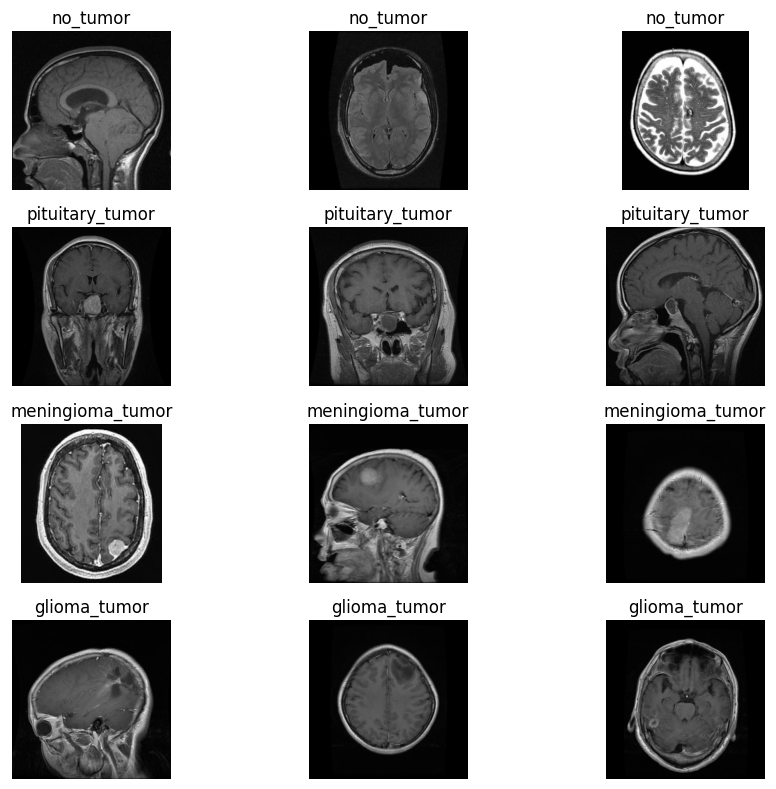

In [25]:
data_dir = "/kaggle/input/braintumor/Training"
categories = os.listdir(data_dir)

image_count = {}
for cat in categories:
    image_count[cat] = len(os.listdir(os.path.join(data_dir, cat)))
print(image_count)

sample_images = []
for cat in categories:
    folder = os.path.join(data_dir, cat)
    files = os.listdir(folder)[:3]
    for file in files:
        img = cv2.imread(os.path.join(folder, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        sample_images.append((img, cat))

plt.figure(figsize=(10,8))
for i, (img, label) in enumerate(sample_images):
    plt.subplot(4,3,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()


# Step 3: Data preprocessing (resize, normalize, clean)

In [41]:
# Step 3: Data Preprocessing (with augmentation)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import math

# Dataset paths
train_dir = "/kaggle/input/braintumor/Training"
test_dir = "/kaggle/input/braintumor/Testing"

# ImageDataGenerator for preprocessing + augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Class mapping
print("Class indices:", train_generator.class_indices)


Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Class indices: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [42]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array(list(train_generator.class_indices.values()))
y_train = train_generator.classes

# Correct usage with keyword arguments
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: 0.8687594553706506, 1: 0.8727203647416414, 2: 1.817246835443038, 3: 0.8674471299093656}


# Step 4: Model (DenseNet121)

In [44]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
print("\n Model Architecture:")


 Model Architecture:


# Step 5: Training 

### Phase-1

In [46]:
# Step 6: Training top layers first
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / train_generator.batch_size),
    validation_data=val_generator,
    validation_steps=math.ceil(val_generator.samples / val_generator.batch_size),
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 810ms/step - accuracy: 0.2704 - loss: 2.3910 - val_accuracy: 0.2199 - val_loss: 1.5345 - learning_rate: 1.0000e-04
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 482ms/step - accuracy: 0.2689 - loss: 1.8999 - val_accuracy: 0.2513 - val_loss: 1.4596 - learning_rate: 1.0000e-04
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 484ms/step - accuracy: 0.3013 - loss: 1.7869 - val_accuracy: 0.3176 - val_loss: 1.3606 - learning_rate: 1.0000e-04
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 482ms/step - accuracy: 0.3050 - loss: 1.7085 - val_accuracy: 0.3717 - val_loss: 1.2857 - learning_rate: 1.0000e-04
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 478ms/step - accuracy: 0.3594 - loss: 1.6322 - val_accuracy: 0.3927 - val_loss: 1.2332 - learning_rate: 1.0000e-04
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 476ms/step - accuracy: 0.3528 - loss: 1.4951 - val_accuracy: 0.4433 - val_loss: 1.1709 - learning_rate: 1.0000e-04
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 498ms/step - acc

In [47]:
# Step 6b: Fine-tuning last layers
base_model.trainable = True
for layer in base_model.layers[:-100]:  # Freeze all except last 100 layers
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / train_generator.batch_size),
    validation_data=val_generator,
    validation_steps=math.ceil(val_generator.samples / val_generator.batch_size),
    epochs=30,  # Train longer during fine-tuning
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.4778 - loss: 1.3114 - val_accuracy: 0.7138 - val_loss: 0.7474 - learning_rate: 1.0000e-05
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 492ms/step - accuracy: 0.6013 - loss: 0.9759 - val_accuracy: 0.7138 - val_loss: 0.7176 - learning_rate: 1.0000e-05
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 487ms/step - accuracy: 0.6597 - loss: 0.8594 - val_accuracy: 0.7312 - val_loss: 0.7015 - learning_rate: 1.0000e-05
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 494ms/step - accuracy: 0.7429 - loss: 0.6754 - val_accuracy: 0.7435 - val_loss: 0.6582 - learning_rate: 1.0000e-05
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 501ms/step - accuracy: 0.7396 - loss: 0.6570 - val_accuracy: 0.7609 - val_loss: 0.6303 - learning_rate: 1.0000e-05
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 496ms/step - accuracy: 0.7679 - loss: 0.6169 - val_accuracy: 0.7749 - val_loss: 0.5716 - learning_rate: 1.0000e-05
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 497ms/step - accur

# Step 6: Evaluation


In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# 1️ Load the best model 
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

# 2️ Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator, steps=math.ceil(test_generator.samples / test_generator.batch_size))
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 587ms/step - accuracy: 0.4841 - loss: 2.6468
Test Accuracy: 67.01%
Test Loss: 1.4890


In [49]:
model.save('saved_model.h5')

## Predictions and Confusion Matrix


13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 903ms/step


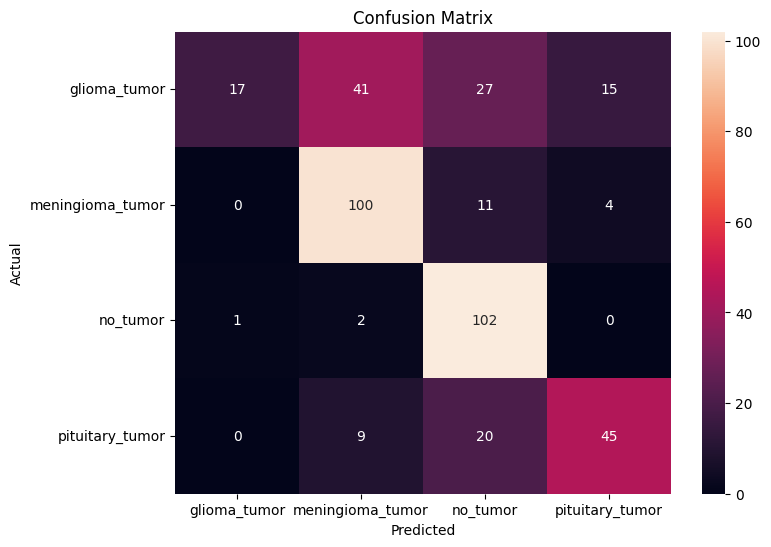

In [50]:
y_pred = model.predict(test_generator, steps=math.ceil(test_generator.samples / test_generator.batch_size))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [51]:
# 4️⃣ Classification Report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.17      0.29       100
meningioma_tumor       0.66      0.87      0.75       115
        no_tumor       0.64      0.97      0.77       105
 pituitary_tumor       0.70      0.61      0.65        74

        accuracy                           0.67       394
       macro avg       0.74      0.65      0.61       394
    weighted avg       0.73      0.67      0.62       394



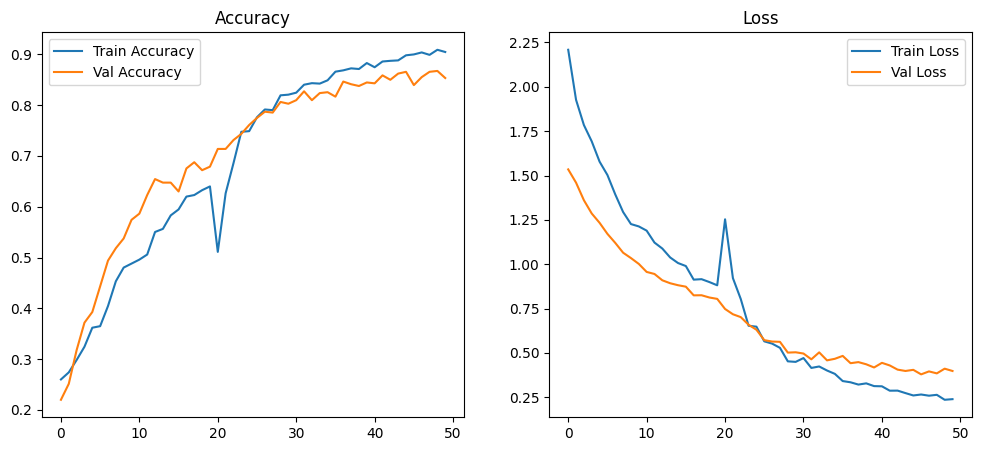

In [52]:
def plot_history(history, fine_tune_history=None):
    # Combine both histories if fine-tuning
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if fine_tune_history:
        acc += fine_tune_history.history['accuracy']
        val_acc += fine_tune_history.history['val_accuracy']
        loss += fine_tune_history.history['loss']
        val_loss += fine_tune_history.history['val_loss']

    # Accuracy plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_history(history, fine_tune_history)


In [53]:
import numpy as np
from tensorflow.keras.losses import CategoricalCrossentropy

# Get predictions and true labels
y_pred = model.predict(test_generator, steps=math.ceil(test_generator.samples / test_generator.batch_size))
y_true = test_generator.classes

# Convert predictions to one-hot
y_pred_onehot = np.zeros_like(y_pred)
y_pred_onehot[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)] = 1

# Compute per-sample loss
loss_fn = CategoricalCrossentropy()
test_losses = loss_fn(y_true=tf.one_hot(y_true, depth=4), y_pred=y_pred).numpy()

# Compute accuracy per sample
y_pred_classes = np.argmax(y_pred, axis=1)
test_accuracies = (y_pred_classes == y_true).astype(float)

print("Mean Test Loss:", np.mean(test_losses))
print("Mean Test Accuracy:", np.mean(test_accuracies))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Mean Test Loss: 1.4889677
Mean Test Accuracy: 0.6700507614213198


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


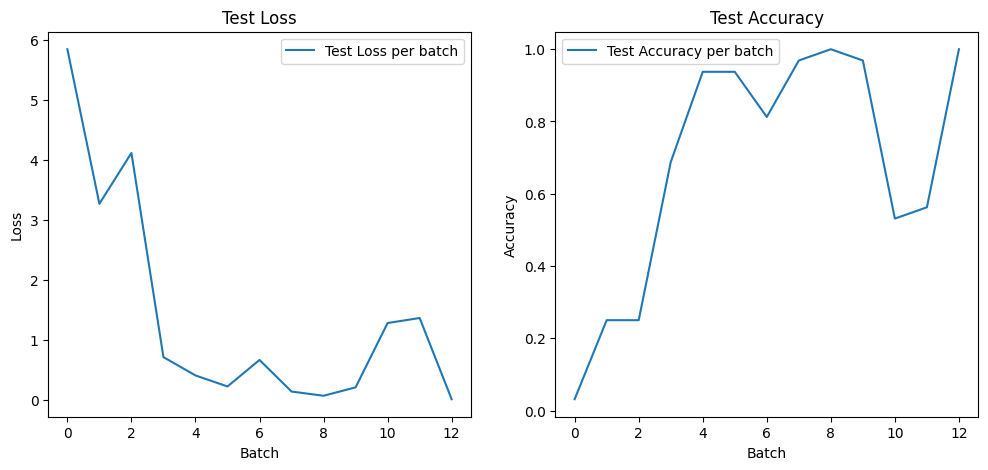

In [54]:
import matplotlib.pyplot as plt
import math

# Batch-wise evaluation
batch_size = test_generator.batch_size
num_batches = math.ceil(test_generator.samples / batch_size)

batch_losses = []
batch_accuracies = []

for i in range(num_batches):
    x_batch, y_batch = test_generator[i]  # Get batch
    batch_pred = model.predict(x_batch)
    
    # Loss
    loss = loss_fn(y_true=y_batch, y_pred=batch_pred).numpy()
    batch_losses.append(loss)
    
    # Accuracy
    acc = np.mean(np.argmax(batch_pred, axis=1) == np.argmax(y_batch, axis=1))
    batch_accuracies.append(acc)

# Plot test loss and accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(batch_losses, label='Test Loss per batch')
plt.title('Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(batch_accuracies, label='Test Accuracy per batch')
plt.title('Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
